In [9]:
import sys
import os

sys.path.append(os.path.abspath('..')) 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
from src.features.time_series import add_rolling_and_lags

# Auto-reload
%load_ext autoreload
%autoreload 2

print("✅ Setup complete!")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Setup complete!


In [12]:
# Load the cleaned data from Phase 3
df_train_clean = pd.read_csv("../data/processed/train_clean.csv")
df_test_clean = pd.read_csv("../data/processed/test_clean.csv")

print("Loaded cleaned data:")
print(f"  Train: {df_train_clean.shape}")
print(f"  Test:  {df_test_clean.shape}")

print("\nTrain columns:")
print(df_train_clean.columns.tolist())

print("\nTest columns:")
print(df_test_clean.columns.tolist())

Loaded cleaned data:
  Train: (20631, 19)
  Test:  (13096, 18)

Train columns:
['engine_number', 'cycle', 'setting_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21', 'RUL_capped']

Test columns:
['engine_number', 'cycle', 'setting_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']


In [13]:
# Create time-series features for training data
df_train_features = add_rolling_and_lags(
    df_train_clean,
    windows=[5, 10],      # Two window sizes
    lags=[1, 3],          # Two lag periods
    drop_originals=True   # Drop original sensors to reduce feature count
)

print("Training data after feature engineering:")
print(f"  Shape: {df_train_features.shape}")
print(f"  Columns: {len(df_train_features.columns)}")


FEATURE ENGINEERING: Rolling Statistics & Lags
📊 Processing 15 sensor columns
   Sensors: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']

🔄 Adding rolling statistics (windows: [5, 10])...
   ✅ Added 60 rolling features (2 windows × 15 sensors × 2)

⏮️ Adding lag features (lags: [1, 3])...
   ✅ Added 30 lag features (2 lags × 15 sensors)

🧹 Handling NaN values...
   NaN count before cleaning: 9,000
   NaN count after cleaning: 0
   Rows dropped due to NaN: 300 (1.5% of original)

🗑️ Dropping original sensor columns (keeping engineered features)...
   Dropped 15 original sensor columns

📈 Feature Engineering Summary:
   Original sensors processed: 15
   Rolling features added: 60
   Lag features added: 30
   Total new features added: 90
   Total modeling features (excluding IDs & target): 91
   Final shape: 20,331 rows × 94 columns
Training data af

In [14]:
# Look at the new feature columns
print("Sample of new feature columns:")
feature_cols = [col for col in df_train_features.columns 
                if col not in ['engine_number', 'cycle', 'RUL', 'RUL_capped']]

print(f"\nTotal feature columns: {len(feature_cols)}")
print("\nFirst 20 feature names:")
for i, col in enumerate(feature_cols[:20], 1):
    print(f"  {i}. {col}")

print("\n...")
print(f"\nLast 10 feature names:")
for col in feature_cols[-10:]:
    print(f"  {col}")

Sample of new feature columns:

Total feature columns: 91

First 20 feature names:
  1. setting_1
  2. sensor_2_mean_5
  3. sensor_2_std_5
  4. sensor_3_mean_5
  5. sensor_3_std_5
  6. sensor_4_mean_5
  7. sensor_4_std_5
  8. sensor_6_mean_5
  9. sensor_6_std_5
  10. sensor_7_mean_5
  11. sensor_7_std_5
  12. sensor_8_mean_5
  13. sensor_8_std_5
  14. sensor_9_mean_5
  15. sensor_9_std_5
  16. sensor_11_mean_5
  17. sensor_11_std_5
  18. sensor_12_mean_5
  19. sensor_12_std_5
  20. sensor_13_mean_5

...

Last 10 feature names:
  sensor_8_lag_3
  sensor_9_lag_3
  sensor_11_lag_3
  sensor_12_lag_3
  sensor_13_lag_3
  sensor_14_lag_3
  sensor_15_lag_3
  sensor_17_lag_3
  sensor_20_lag_3
  sensor_21_lag_3


In [15]:
# Look at one engine to verify features make sense
engine_id = 1
engine_data = df_train_features[df_train_features['engine_number'] == engine_id].head(15)

print(f"Engine {engine_id} - First 15 cycles:")
print("\nOriginal identifiers:")
display(engine_data[['engine_number', 'cycle', 'RUL_capped']])

print("\nExample rolling features (sensor_2):")
rolling_cols = [col for col in engine_data.columns if 'sensor_2_mean' in col or 'sensor_2_std' in col]
display(engine_data[['cycle'] + rolling_cols])

print("\nExample lag features (sensor_2):")
lag_cols = [col for col in engine_data.columns if 'sensor_2_lag' in col]
display(engine_data[['cycle'] + lag_cols])

Engine 1 - First 15 cycles:

Original identifiers:


,engine_number,cycle,RUL_capped
0,1,4,130
1,1,5,130
2,1,6,130
3,1,7,130
4,1,8,130
5,1,9,130
6,1,10,130
7,1,11,130
8,1,12,130
9,1,13,130



Example rolling features (sensor_2):


,cycle,sensor_2_mean_5,sensor_2_std_5,sensor_2_mean_10,sensor_2_std_10
0,4,642.1675,0.250117,642.167500,0.250117
1,5,642.2080,0.234776,642.208000,0.234776
2,6,642.2640,0.128374,642.190000,0.214569
3,7,642.3300,0.139463,642.231429,0.224457
4,8,642.3720,0.174270,642.272500,0.238073
5,9,642.3260,0.208519,642.255556,0.228425
6,10,642.1940,0.340705,642.201000,0.275941
7,11,642.2300,0.337787,642.247000,0.241571
8,12,642.1460,0.311256,642.238000,0.247198
9,13,642.2480,0.504450,642.310000,0.361755



Example lag features (sensor_2):


,cycle,sensor_2_lag_1,sensor_2_lag_3
0,4,642.35,641.82
1,5,642.35,642.15
2,6,642.37,642.35
3,7,642.10,642.35
4,8,642.48,642.37
5,9,642.56,642.10
6,10,642.12,642.48
7,11,641.71,642.56
8,12,642.28,642.12
9,13,642.06,641.71


In [16]:
# Apply SAME transformations to test data
df_test_features = add_rolling_and_lags(
    df_test_clean,
    windows=[5, 10],      # Same windows as train
    lags=[1, 3],          # Same lags as train
    drop_originals=True   # Same as train
)

print("\n" + "="*60)
print("Test data after feature engineering:")
print(f"  Shape: {df_test_features.shape}")
print(f"  Columns: {len(df_test_features.columns)}")

FEATURE ENGINEERING: Rolling Statistics & Lags
📊 Processing 15 sensor columns
   Sensors: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']

🔄 Adding rolling statistics (windows: [5, 10])...
   ✅ Added 60 rolling features (2 windows × 15 sensors × 2)

⏮️ Adding lag features (lags: [1, 3])...
   ✅ Added 30 lag features (2 lags × 15 sensors)

🧹 Handling NaN values...
   NaN count before cleaning: 9,000
   NaN count after cleaning: 0
   Rows dropped due to NaN: 300 (2.3% of original)

🗑️ Dropping original sensor columns (keeping engineered features)...
   Dropped 15 original sensor columns

📈 Feature Engineering Summary:
   Original sensors processed: 15
   Rolling features added: 60
   Lag features added: 30
   Total new features added: 90
   Total modeling features (excluding IDs & target): 91
   Final shape: 12,796 rows × 93 columns

Test data after

In [17]:
# CRITICAL: Verify train and test have same features
train_features = [col for col in df_train_features.columns 
                  if col not in ['engine_number', 'cycle', 'RUL', 'RUL_capped']]
test_features = [col for col in df_test_features.columns 
                 if col not in ['engine_number', 'cycle']]

print("Feature consistency check:")
print(f"Train features: {len(train_features)}")
print(f"Test features:  {len(test_features)}")

if train_features == test_features:
    print("\n✅ SUCCESS! Train and test have IDENTICAL features")
    print("   Both datasets ready for modeling")
else:
    print("\n❌ MISMATCH detected!")
    train_only = set(train_features) - set(test_features)
    test_only = set(test_features) - set(train_features)
    
    if train_only:
        print(f"\n   Train-only features ({len(train_only)}):")
        for f in sorted(train_only):
            print(f"     - {f}")
    
    if test_only:
        print(f"\n   Test-only features ({len(test_only)}):")
        for f in sorted(test_only):
            print(f"     - {f}")



Feature consistency check:
Train features: 91
Test features:  91

✅ SUCCESS! Train and test have IDENTICAL features
   Both datasets ready for modeling


✅ Saved: figures/feature_eng_rolling_mean.png


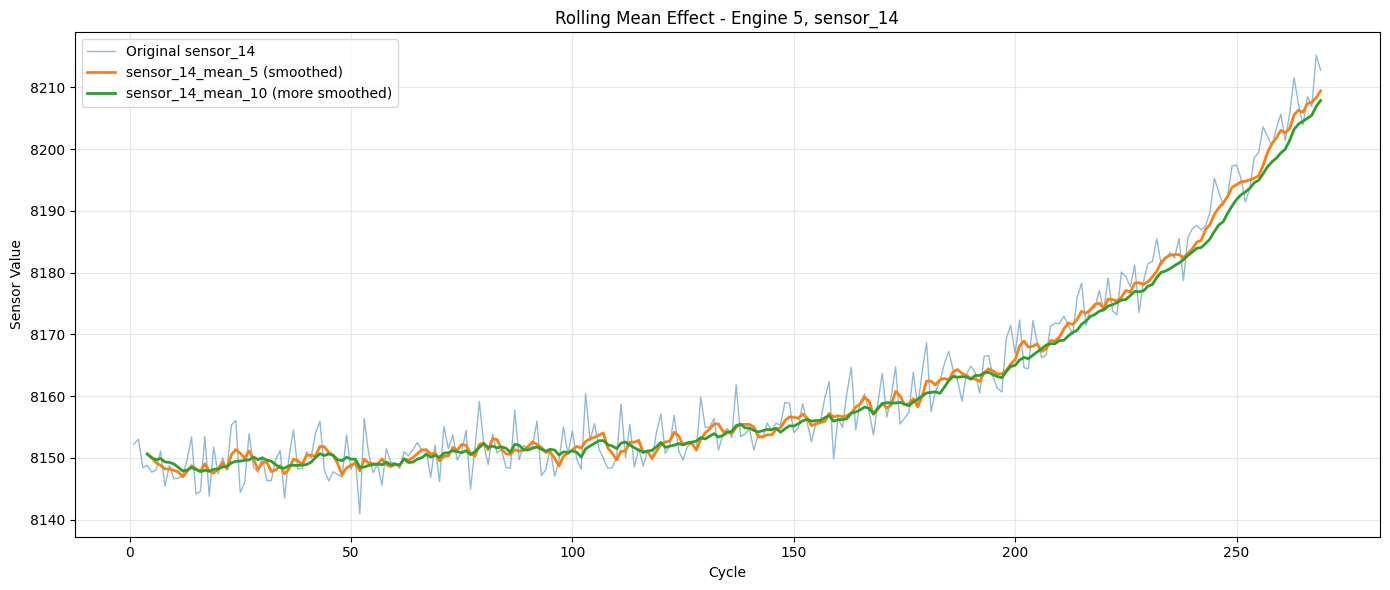

In [18]:
# Visualize rolling mean effect for one sensor on one engine
engine_id = 5
engine_data = df_train_clean[df_train_clean['engine_number'] == engine_id]
engine_features = df_train_features[df_train_features['engine_number'] == engine_id]

sensor = 'sensor_14'  # One of the important sensors from EDA

plt.figure(figsize=(14, 6))

# Plot original sensor (if we kept it) vs rolling means
plt.plot(engine_data['cycle'], engine_data[sensor], 
         label=f'Original {sensor}', alpha=0.5, linewidth=1)
plt.plot(engine_features['cycle'], engine_features[f'{sensor}_mean_5'], 
         label=f'{sensor}_mean_5 (smoothed)', linewidth=2)
plt.plot(engine_features['cycle'], engine_features[f'{sensor}_mean_10'], 
         label=f'{sensor}_mean_10 (more smoothed)', linewidth=2)

plt.xlabel('Cycle')
plt.ylabel('Sensor Value')
plt.title(f'Rolling Mean Effect - Engine {engine_id}, {sensor}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/feature_eng_rolling_mean.png', dpi=300, bbox_inches='tight')
print("✅ Saved: figures/feature_eng_rolling_mean.png")
plt.show()

✅ Saved: figures/feature_eng_rolling_std.png


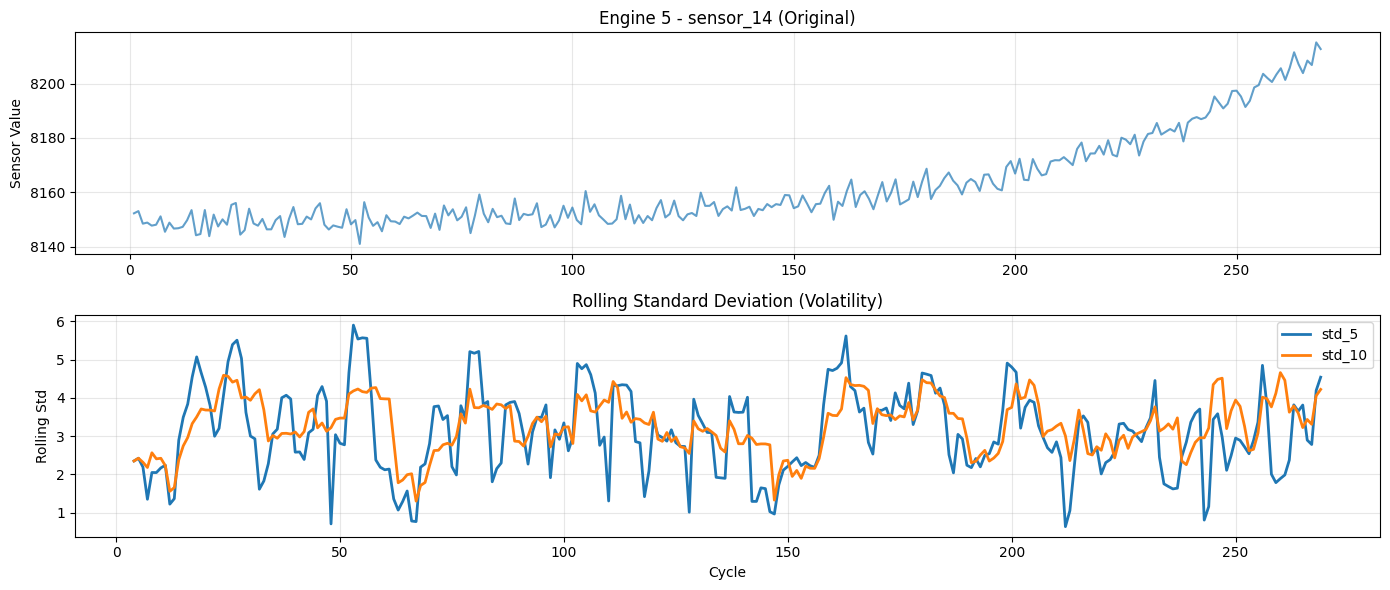


💡 Insight: Increasing std near failure may indicate instability


In [19]:
# Visualize rolling std - shows how volatile/noisy the sensor is
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(engine_data['cycle'], engine_data[sensor], alpha=0.7)
plt.ylabel('Sensor Value')
plt.title(f'Engine {engine_id} - {sensor} (Original)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(engine_features['cycle'], engine_features[f'{sensor}_std_5'], 
         label='std_5', linewidth=2)
plt.plot(engine_features['cycle'], engine_features[f'{sensor}_std_10'], 
         label='std_10', linewidth=2)
plt.xlabel('Cycle')
plt.ylabel('Rolling Std')
plt.title(f'Rolling Standard Deviation (Volatility)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/feature_eng_rolling_std.png', dpi=300, bbox_inches='tight')
print("✅ Saved: figures/feature_eng_rolling_std.png")
plt.show()

print("\n💡 Insight: Increasing std near failure may indicate instability")

✅ Saved: figures/feature_eng_lag_features.png


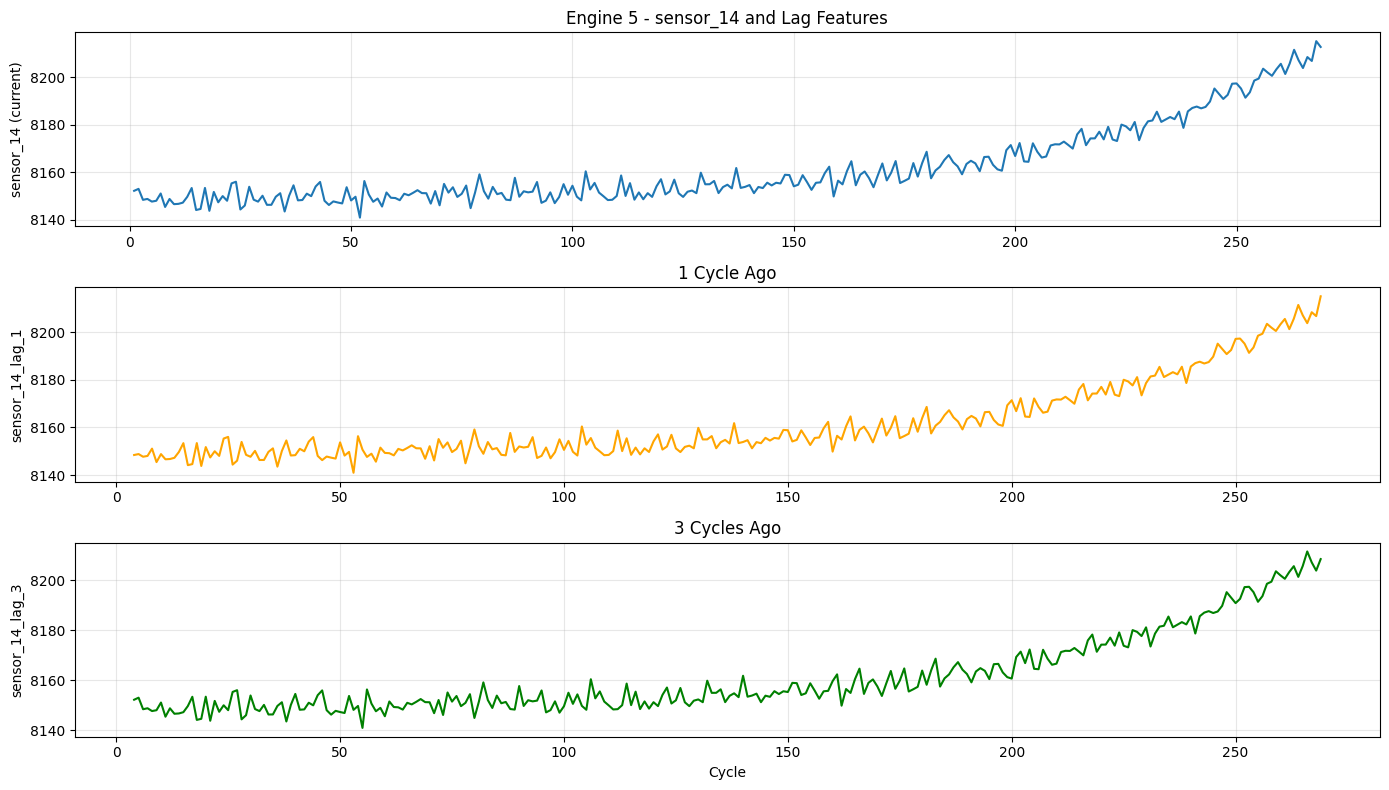


💡 Insight: Lag features help model understand rate of change


In [20]:
# Show how lag features capture history
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(engine_data['cycle'], engine_data[sensor])
plt.ylabel(f'{sensor} (current)')
plt.title(f'Engine {engine_id} - {sensor} and Lag Features')
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(engine_features['cycle'], engine_features[f'{sensor}_lag_1'], color='orange')
plt.ylabel(f'{sensor}_lag_1')
plt.title('1 Cycle Ago')
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(engine_features['cycle'], engine_features[f'{sensor}_lag_3'], color='green')
plt.xlabel('Cycle')
plt.ylabel(f'{sensor}_lag_3')
plt.title('3 Cycles Ago')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/feature_eng_lag_features.png', dpi=300, bbox_inches='tight')
print("✅ Saved: figures/feature_eng_lag_features.png")
plt.show()

print("\n💡 Insight: Lag features help model understand rate of change")

Top 20 features most correlated with RUL_capped:
 1. sensor_17_mean_10              : -0.8145
 2. sensor_4_mean_5                : -0.8141
 3. sensor_4_mean_10               : -0.8128
 4. sensor_15_mean_10              : -0.8126
 5. sensor_11_mean_5               : -0.8124
 6. sensor_3_mean_10               : -0.8103
 7. sensor_15_mean_5               : -0.8085
 8. sensor_21_mean_10              : +0.8085
 9. sensor_11_mean_10              : -0.8074
10. sensor_20_mean_10              : +0.8074
11. sensor_21_mean_5               : +0.8030
12. sensor_2_mean_10               : -0.8030
13. sensor_17_mean_5               : -0.8021
14. sensor_20_mean_5               : +0.8013
15. sensor_3_mean_5                : -0.7939
16. sensor_2_mean_5                : -0.7933
17. sensor_12_mean_5               : +0.7917
18. sensor_7_mean_5                : +0.7915
19. sensor_7_mean_10               : +0.7892
20. sensor_12_mean_10              : +0.7873

✅ Saved: figures/feature_eng_correlation.png


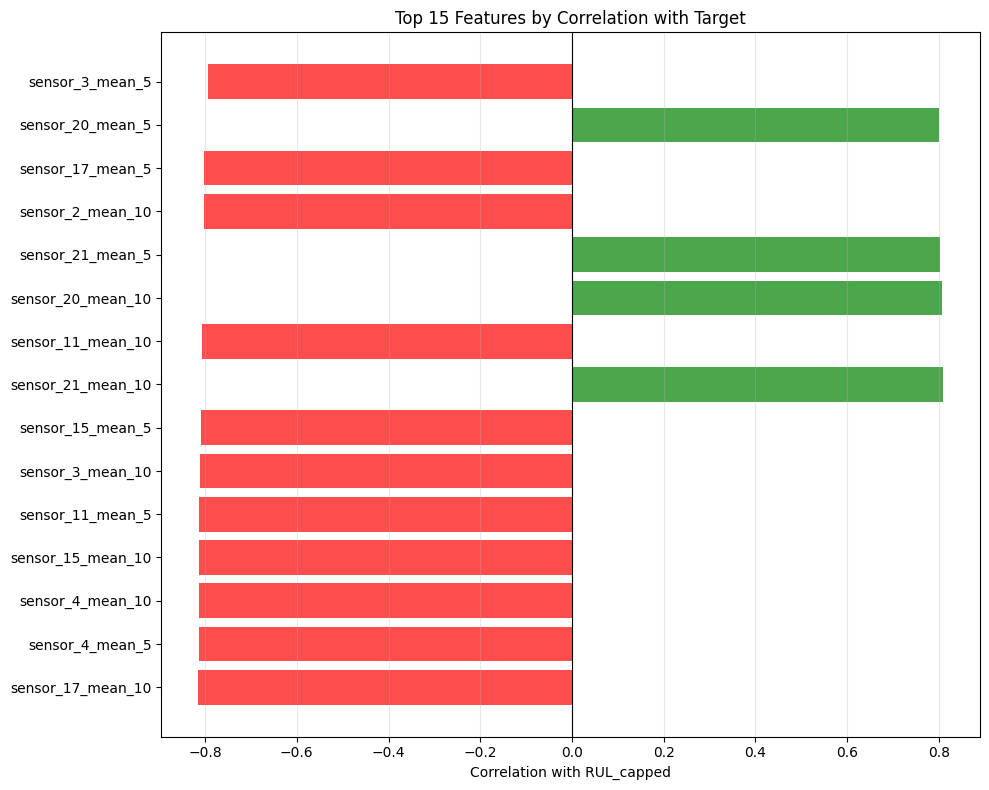

In [21]:
# Check correlation of new features with target (RUL_capped)
feature_cols = [col for col in df_train_features.columns 
                if col not in ['engine_number', 'cycle', 'RUL', 'RUL_capped']]

# Calculate correlation with target
correlations = df_train_features[feature_cols + ['RUL_capped']].corr()['RUL_capped'].drop('RUL_capped')

# Sort by absolute correlation
correlations_sorted = correlations.abs().sort_values(ascending=False)

print("Top 20 features most correlated with RUL_capped:")

for i, (feature, corr) in enumerate(correlations_sorted.head(20).items(), 1):
    actual_corr = correlations[feature]
    print(f"{i:2d}. {feature:30s} : {actual_corr:+.4f}")

# Visualize top 15
plt.figure(figsize=(10, 8))
top_features = correlations_sorted.head(15)
colors = ['green' if correlations[f] > 0 else 'red' for f in top_features.index]

plt.barh(range(len(top_features)), 
         [correlations[f] for f in top_features.index],
         color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Correlation with RUL_capped')
plt.title('Top 15 Features by Correlation with Target')
plt.grid(True, alpha=0.3, axis='x')
plt.axvline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.savefig('../figures/feature_eng_correlation.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: figures/feature_eng_correlation.png")
plt.show()

In [22]:
# Save the featured datasets
train_save_path = "../data/processed/train_features.csv"
test_save_path = "../data/processed/test_features.csv"

df_train_features.to_csv(train_save_path, index=False)
print(f"✅ Saved training features to: {train_save_path}")
print(f"   Shape: {df_train_features.shape}")

df_test_features.to_csv(test_save_path, index=False)
print(f"✅ Saved test features to: {test_save_path}")
print(f"   Shape: {df_test_features.shape}")

# Check file sizes
import os
train_size = os.path.getsize(train_save_path) / (1024 * 1024)
test_size = os.path.getsize(test_save_path) / (1024 * 1024)

print(f"\nFile sizes:")
print(f"  train_features.csv: {train_size:.2f} MB")
print(f"  test_features.csv:  {test_size:.2f} MB")

✅ Saved training features to: ../data/processed/train_features.csv
   Shape: (20331, 94)
✅ Saved test features to: ../data/processed/test_features.csv
   Shape: (12796, 93)

File sizes:
  train_features.csv: 21.46 MB
  test_features.csv:  13.50 MB


In [23]:
# Summary of what we created

print("FEATURE ENGINEERING COMPLETE")


print("\nDataset Shapes:")
print(f"  Training:   {df_train_features.shape[0]:,} rows × {df_train_features.shape[1]} columns")
print(f"  Test:       {df_test_features.shape[0]:,} rows × {df_test_features.shape[1]} columns")

print("\nFeature Breakdown:")
print(f"  Settings:              3  (setting_1, setting_2, setting_3)")
print(f"  Rolling features:     60  (15 sensors × 2 windows × 2 stats)")
print(f"  Lag features:         30  (15 sensors × 2 lags)")
print(f"  Identifiers:           2  (engine_number, cycle)")
print(f"  Target (train only):   2  (RUL, RUL_capped)")
print(f"  {'─'*58}")
print(f"  Total feature columns: {len(feature_cols)}")

print("\nData Quality:")
print(f"  Train NaN count: {df_train_features.isnull().sum().sum()}")
print(f"  Test NaN count:  {df_test_features.isnull().sum().sum()}")
print(f"  Train duplicates: {df_train_features.duplicated().sum()}")
print(f"  Test duplicates:  {df_test_features.duplicated().sum()}")

print("\n✅ Ready for Phase 5: Scaling and Splitting!")


FEATURE ENGINEERING COMPLETE

Dataset Shapes:
  Training:   20,331 rows × 94 columns
  Test:       12,796 rows × 93 columns

Feature Breakdown:
  Settings:              3  (setting_1, setting_2, setting_3)
  Rolling features:     60  (15 sensors × 2 windows × 2 stats)
  Lag features:         30  (15 sensors × 2 lags)
  Identifiers:           2  (engine_number, cycle)
  Target (train only):   2  (RUL, RUL_capped)
  ──────────────────────────────────────────────────────────
  Total feature columns: 91

Data Quality:
  Train NaN count: 0
  Test NaN count:  0
  Train duplicates: 0
  Test duplicates:  0

✅ Ready for Phase 5: Scaling and Splitting!


# Feature Engineering Summary

## Transformations Applied

### Rolling Statistics (Windows: 5, 10)
- **Rolling Mean**: Smooths sensor values, captures trends
- **Rolling Std**: Captures volatility/instability
- **Result**: 15 sensors × 2 windows × 2 stats = **60 features**

### Lag Features (Lags: 1, 3)
- **Lag 1**: Sensor value from 1 cycle ago
- **Lag 3**: Sensor value from 3 cycles ago
- **Purpose**: Model learns rate of change
- **Result**: 15 sensors × 2 lags = **30 features**

### Total Engineered Features
- Original sensors: **DROPPED** (to reduce redundancy)
- Settings: **3** (kept)
- Engineered features: **90** (rolling + lag)
- **Total feature count**: ~**93 columns**

## Key Decisions

1. ✅ **Moderate windows** [5, 10] - not too many, keeps model fast
2. ✅ **Dropped original sensors** - engineered features capture same info better
3. ✅ **Same transformations for train/test** - critical for consistency
4. ✅ **Handled NaN from lags** - dropped rows with missing values

## Results

| Dataset | Rows | Columns | Features | Target |
|---------|------|---------|----------|--------|
| Train | ~20,XXX | ~100 | 93 | RUL_capped |
| Test | ~13,XXX | ~98 | 93 | None |

## Visualizations Created
1. Rolling mean smoothing effect
2. Rolling std (volatility indicator)
3. Lag features (historical values)
4. Feature correlation with target

## Next Steps
- **Phase 5**: Scale features and split by engines
- **Phase 6**: Train models (Linear Regression → Ridge → Random Forest)
```

---

## 🎉 PHASE 4 COMPLETE!

You now have:
- ✅ Reusable feature engineering module (`src/features/time_series.py`)
- ✅ ~90 engineered features (rolling stats + lags)
- ✅ Total ~93 feature columns (manageable for Random Forest)
- ✅ Identical features in train and test
- ✅ No NaN values
- ✅ Saved CSVs: `train_features.csv`, `test_features.csv`
- ✅ 4 visualization plots explaining features

---

## 📊 KEY FILES CREATED
```
data/processed/
├── train_features.csv    (~20,XXX rows × ~100 columns)
└── test_features.csv     (~13,XXX rows × ~98 columns)

figures/
├── feature_eng_rolling_mean.png
├── feature_eng_rolling_std.png
├── feature_eng_lag_features.png
└── feature_eng_correlation.png

src/features/
└── time_series.py        (reusable functions)